# Time series prediction using LSTM

### Goals: Correct use of TensorFlow library to predict air quality data using multivariate time series data
Dataset used: https://archive.ics.uci.edu/ml/datasets/Air+Quality

Steps:

- EDA (done)
- Handling null values (done)
- preparing sequences 
- preparing data for training and testing
- plotting the model's performance on test data

I will also use a basic learning rate scheduling

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10
import pandas as pd



In [2]:
data = pd.read_csv('data_preprocessed.csv')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,0.955511,1360.0,150.0,2.476538,1046.0,5.111988,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,0.693147,1292.0,112.0,2.240710,955.0,4.634729,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,0.788457,1402.0,88.0,2.197225,939.0,4.875197,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,0.788457,1376.0,80.0,2.219203,948.0,5.147494,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,0.470004,1272.0,51.0,1.871802,836.0,4.875197,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


How to deal with the time values? Well since the date column does not contain unique values, I should join time to date as the new ID column

In [3]:
data['Time'].value_counts()

23.00.00    390
06.00.00    390
00.00.00    390
21.00.00    390
04.00.00    390
03.00.00    390
22.00.00    390
13.00.00    390
11.00.00    390
09.00.00    390
02.00.00    390
20.00.00    390
10.00.00    390
01.00.00    390
19.00.00    390
14.00.00    390
12.00.00    390
07.00.00    390
18.00.00    390
08.00.00    390
05.00.00    390
17.00.00    389
16.00.00    389
15.00.00    389
Name: Time, dtype: int64

In [4]:
data = data.set_index(['Date','Time']) #lets try going with a multiindex
data.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
Date       Time                                                                 
10/03/2004 18.00.00  0.955511       1360.0     150.0  2.476538         1046.0   
           19.00.00  0.693147       1292.0     112.0  2.240710          955.0   
           20.00.00  0.788457       1402.0      88.0  2.197225          939.0   
           21.00.00  0.788457       1376.0      80.0  2.219203          948.0   
           22.00.00  0.470004       1272.0      51.0  1.871802          836.0   

                      NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
Date       Time                                                      
10/03/2004 18.00.00  5.111988        1056.0    113.0        1692.0   
           19.00.00  4.634729        1174.0     92.0        1559.0   
           20.00.00  4.875197        1140.0    114.0        1555.0   
           21.00.00  5.147494        1092.0    122.0        1584.0   
           22.00.00  4.875197        1205.0    116.0        1490.0   

                     PT08.S5(O3)     T    RH      AH  
Date       Time                                       
10/03/2004 18.00.00       1268.0  13.6  48.9  0.7578  
           19.00.00        972.0  13.3  47.7  0.7255  
           20.00.00       1074.0  11.9  54.0  0.7502  
           21.00.00       1203.0  11.0  60.0  0.7867  
           22.00.00       1110.0  11.2  59.6  0.7888

In [5]:
data.tail()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
Date       Time                                                                 
04/04/2005 10.00.00  1.131402       1314.0     275.0  2.602690         1101.0   
           11.00.00  0.875469       1163.0     275.0  2.433613         1027.0   
           12.00.00  0.875469       1142.0     275.0  2.517696         1063.0   
           13.00.00  0.741937       1003.0     275.0  2.251292          961.0   
           14.00.00  0.788457       1071.0     275.0  2.476538         1047.0   

                      NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
Date       Time                                                      
04/04/2005 10.00.00  6.156979         539.0    190.0        1374.0   
           11.00.00  5.866468         604.0    179.0        1264.0   
           12.00.00  5.680173         603.0    175.0        1241.0   
           13.00.00  5.459586         702.0    156.0        1041.0   
           14.00.00  5.579730         654.0    168.0        1129.0   

                     PT08.S5(O3)     T    RH      AH  
Date       Time                                       
04/04/2005 10.00.00       1729.0  21.9  29.3  0.7568  
           11.00.00       1269.0  24.3  23.7  0.7119  
           12.00.00       1092.0  26.9  18.3  0.6406  
           13.00.00        770.0  28.3  13.5  0.5139  
           14.00.00        816.0  28.5  13.1  0.5028

In [6]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

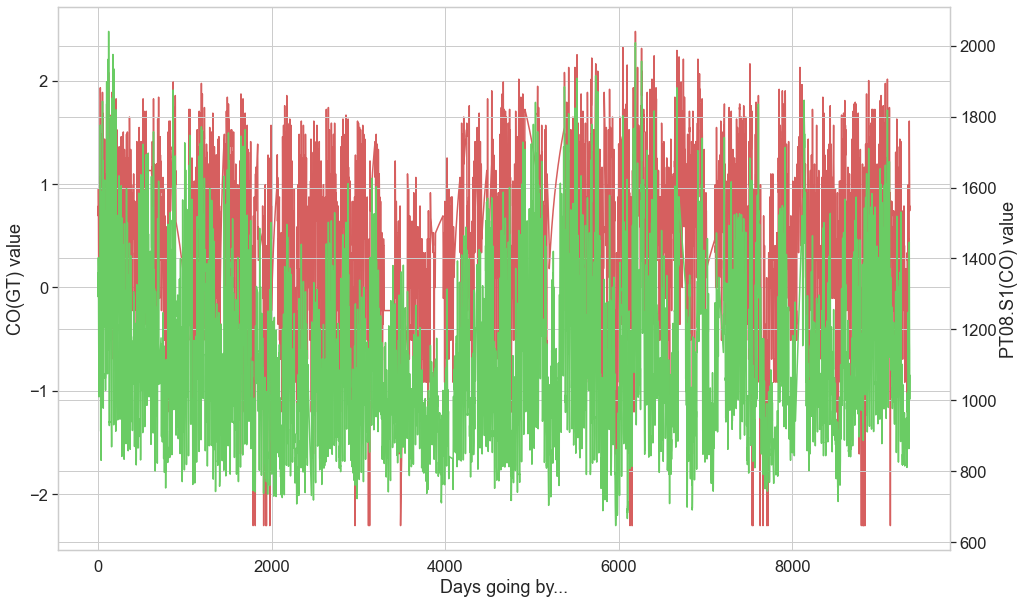

In [7]:
#understanding the data better, I believe the reference columns should be deleted
fig, ax = plt.subplots()
ax.plot(data['CO(GT)'].to_numpy(), 'r')
ax.set_xlabel('Days going by...')
ax.set_ylabel('CO(GT) value')

ax2 = ax.twinx()
ax2.plot(data['PT08.S1(CO)'].to_numpy(), 'g')
ax2.set_ylabel('PT08.S1(CO) value')
plt.show()

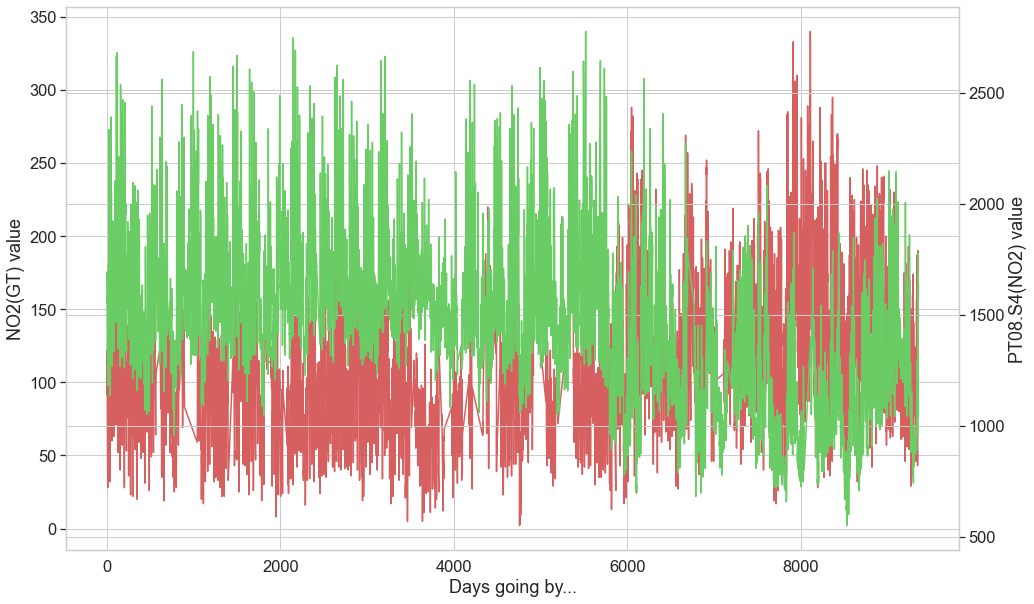

In [8]:
fig, ax = plt.subplots()
ax.plot(data['NO2(GT)'].to_numpy(), 'r')
ax.set_xlabel('Days going by...')
ax.set_ylabel('NO2(GT) value')

ax2 = ax.twinx()
ax2.plot(data['PT08.S4(NO2)'].to_numpy(), 'g')
ax2.set_ylabel('PT08.S4(NO2) value')
plt.show()

Okay, so there's probably not straight multicollinearity problem, let's pretend all the sensor values are independent and think about the value to predict...

I chose RELATIVE HUMIDITY

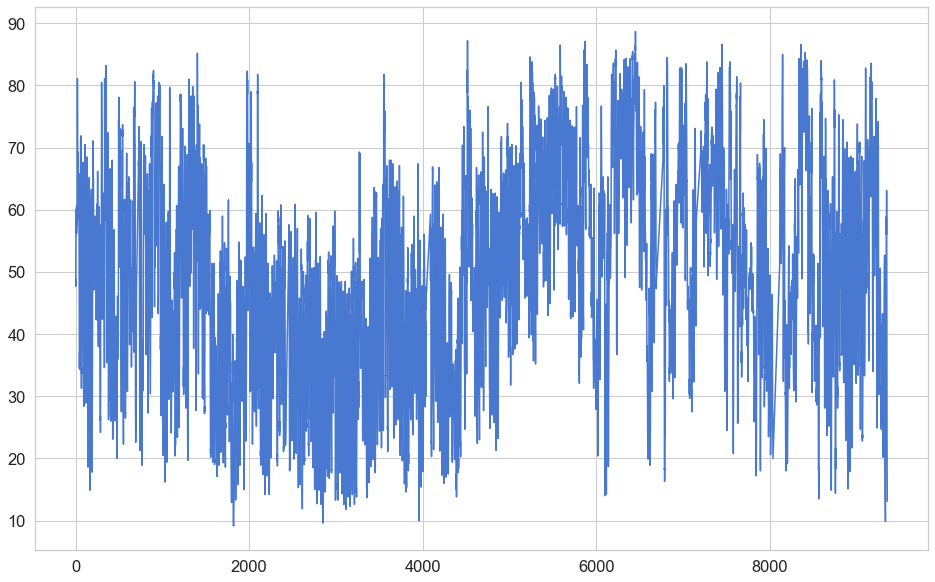

In [9]:
plt.plot(data['RH'].to_numpy())
plt.show()

In [10]:
targets = data.pop('RH')
targets

Date        Time    
10/03/2004  18.00.00    48.9
            19.00.00    47.7
            20.00.00    54.0
            21.00.00    60.0
            22.00.00    59.6
                        ... 
04/04/2005  10.00.00    29.3
            11.00.00    23.7
            12.00.00    18.3
            13.00.00    13.5
            14.00.00    13.1
Name: RH, Length: 9357, dtype: float64

In [11]:
#scale the data using robust scaler more immune to outliers
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_feats = scaler.fit_transform(data)
df = pd.DataFrame(scaled_feats, index = data.index, columns = data.columns)
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
Date       Time                                                                 
10/03/2004 18.00.00  0.379332     0.973422    -125.0  0.315457       0.355057   
           19.00.00  0.108686     0.747508    -163.0  0.108970       0.117460   
           20.00.00  0.207005     1.112957    -187.0  0.070895       0.075684   
           21.00.00  0.207005     1.026578    -195.0  0.090139       0.099183   
           22.00.00 -0.121501     0.681063    -224.0 -0.214039      -0.193245   

                      NOx(GT)  PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  \
Date       Time                                                       
10/03/2004 18.00.00 -0.066230      0.802548  0.134005      0.526077   
           19.00.00 -0.456610      1.178344 -0.214169      0.224490   
           20.00.00 -0.259916      1.070064  0.150585      0.215420   
           21.00.00 -0.037187      0.917197  0.283222      0.281179   
           22.00.00 -0.259916      1.277070  0.183744      0.068027   

                     PT08.S5(O3)         T        AH  
Date       Time                                       
10/03/2004 18.00.00     0.532143 -0.317460 -0.403377  
           19.00.00     0.003571 -0.341270 -0.459610  
           20.00.00     0.185714 -0.452381 -0.416609  
           21.00.00     0.416071 -0.523810 -0.353064  
           22.00.00     0.250000 -0.507937 -0.349408

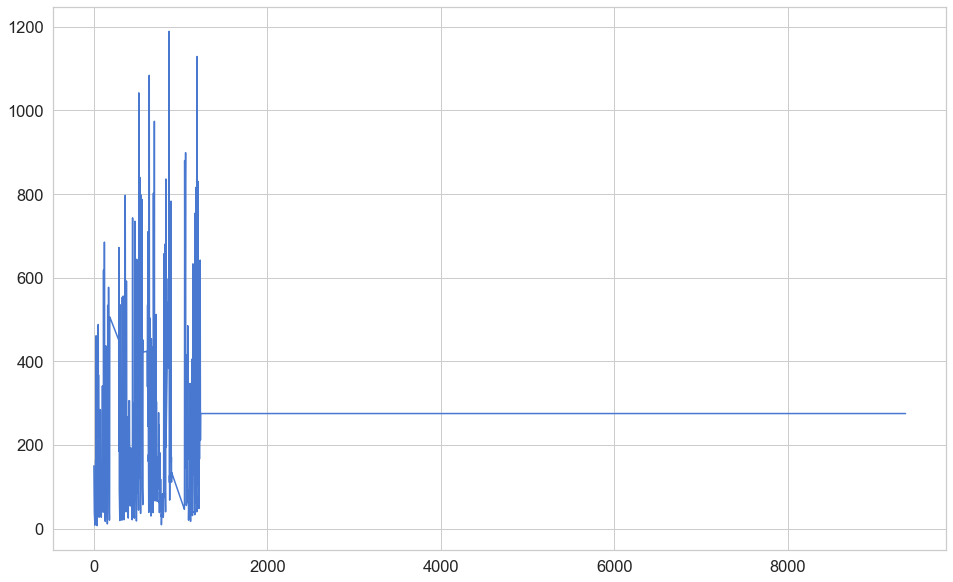

In [12]:
#apparently there's an issue with the third column 

plt.plot(data['NMHC(GT)'].to_numpy())
plt.show()

In [13]:
#the variable consists mostly of the interpolated data! we drop this feature.
df.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'AH'],
      dtype='object')

In [14]:
df.drop('NMHC(GT)', axis=1, inplace=True)

In [15]:
df.head()

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
Date       Time                                                                 
10/03/2004 18.00.00  0.379332     0.973422  0.315457       0.355057 -0.066230   
           19.00.00  0.108686     0.747508  0.108970       0.117460 -0.456610   
           20.00.00  0.207005     1.112957  0.070895       0.075684 -0.259916   
           21.00.00  0.207005     1.026578  0.090139       0.099183 -0.037187   
           22.00.00 -0.121501     0.681063 -0.214039      -0.193245 -0.259916   

                     PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
Date       Time                                                          
10/03/2004 18.00.00      0.802548  0.134005      0.526077     0.532143   
           19.00.00      1.178344 -0.214169      0.224490     0.003571   
           20.00.00      1.070064  0.150585      0.215420     0.185714   
           21.00.00      0.917197  0.283222      0.281179     0.416071   
           22.00.00      1.277070  0.183744      0.068027     0.250000   

                            T        AH  
Date       Time                          
10/03/2004 18.00.00 -0.317460 -0.403377  
           19.00.00 -0.341270 -0.459610  
           20.00.00 -0.452381 -0.416609  
           21.00.00 -0.523810 -0.353064  
           22.00.00 -0.507937 -0.349408

So at this point, we have df with features and targets with target values and it's time to perform sequencing and tt split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
def sequence(X, targets, time_steps = 1):
    '''This function creates sequences of data - Xs of size time_steps and the corresponding ys as a simple array'''
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(targets.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)
    

In [18]:
#how long should the test set be?

len(df)

9357

In [19]:
#let's merge the targets back, that will be easier
df['target'] = targets

In [20]:
df.head()

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
Date       Time                                                                 
10/03/2004 18.00.00  0.379332     0.973422  0.315457       0.355057 -0.066230   
           19.00.00  0.108686     0.747508  0.108970       0.117460 -0.456610   
           20.00.00  0.207005     1.112957  0.070895       0.075684 -0.259916   
           21.00.00  0.207005     1.026578  0.090139       0.099183 -0.037187   
           22.00.00 -0.121501     0.681063 -0.214039      -0.193245 -0.259916   

                     PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
Date       Time                                                          
10/03/2004 18.00.00      0.802548  0.134005      0.526077     0.532143   
           19.00.00      1.178344 -0.214169      0.224490     0.003571   
           20.00.00      1.070064  0.150585      0.215420     0.185714   
           21.00.00      0.917197  0.283222      0.281179     0.416071   
           22.00.00      1.277070  0.183744      0.068027     0.250000   

                            T        AH  target  
Date       Time                                  
10/03/2004 18.00.00 -0.317460 -0.403377    48.9  
           19.00.00 -0.341270 -0.459610    47.7  
           20.00.00 -0.452381 -0.416609    54.0  
           21.00.00 -0.523810 -0.353064    60.0  
           22.00.00 -0.507937 -0.349408    59.6

In [21]:
#let's have 8% of the data as test rows 

train_size = int(len(data)*0.92)

train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(len(train),len(test))




8608 749


In [22]:
time_steps = 30 #sequences of 30, we have a lot of data anyway
X_train, y_train = sequence(train, train.target, time_steps)
X_test, y_test = sequence(test, test.target, time_steps)
print(X_train.shape, y_train.shape)

(8578, 30, 12) (8578,)


At this point we have the sequences ready for training. We can build the model. Functional API or pass a list to Sequential...? Let's pass a list to Sequential using Bidirectional LSTM for starters.

In [23]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

def train_model(X, y, do=0.3, lr=0.001, eps = 100, bs = 32, vs = 0.1, pat=3):
    model = keras.Sequential([
        keras.layers.Bidirectional(
            keras.layers.LSTM(128, input_shape = (X[0].shape), return_sequences = True)),
        keras.layers.Dropout(do),
        keras.layers.Bidirectional(
            keras.layers.LSTM(128)),
        keras.layers.Dropout(do),
        keras.layers.Dense(1) #no activation since this is a regression task
    ])
    #let's try implementing lr scheduling 
    ES = keras.callbacks.EarlyStopping(patience=pat, monitor = 'val_loss', restore_best_weights = True)
    SC = keras.callbacks.LearningRateScheduler(scheduler)
    callbacks = [ES, SC]
    adam = keras.optimizers.Adam(learning_rate = lr)
    model.compile(loss='mean_squared_error', optimizer = adam, metrics = [tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(X,y, epochs = eps, batch_size = bs, validation_split = vs, verbose = 1,
                        shuffle = False, callbacks = callbacks)
    
    return model, history

In [24]:
def plot_history(history):
    plt.figure(figsize = (16,10))
    plt.plot(history.history['loss'], label = 'Training loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.title('Training history (MSE)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,10))
    plt.plot(history.history['root_mean_squared_error'], label = 'Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label = 'Validation RMSE')
    plt.title('Training RMSE')
    plt.legend()
    plt.show()

In [25]:
model_1, history_1 = train_model(X_train, y_train)

Epoch 1/100
242/242 [==============================] - 14s 57ms/step - loss: 503.7064 - root_mean_squared_error: 22.4434 - val_loss: 328.7431 - val_root_mean_squared_error: 18.1313
Epoch 2/100
242/242 [==============================] - 13s 54ms/step - loss: 206.2471 - root_mean_squared_error: 14.3613 - val_loss: 74.7130 - val_root_mean_squared_error: 8.6437
Epoch 3/100
242/242 [==============================] - 13s 55ms/step - loss: 59.8595 - root_mean_squared_error: 7.7369 - val_loss: 46.4207 - val_root_mean_squared_error: 6.8133
Epoch 4/100
242/242 [==============================] - 14s 57ms/step - loss: 41.4964 - root_mean_squared_error: 6.4418 - val_loss: 28.9718 - val_root_mean_squared_error: 5.3825
Epoch 5/100
242/242 [==============================] - 14s 57ms/step - loss: 31.0061 - root_mean_squared_error: 5.5683 - val_loss: 21.1132 - val_root_mean_squared_error: 4.5949
Epoch 6/100
242/242 [==============================] - 14s 57ms/step - loss: 27.6951 - root_mean_squared_erro

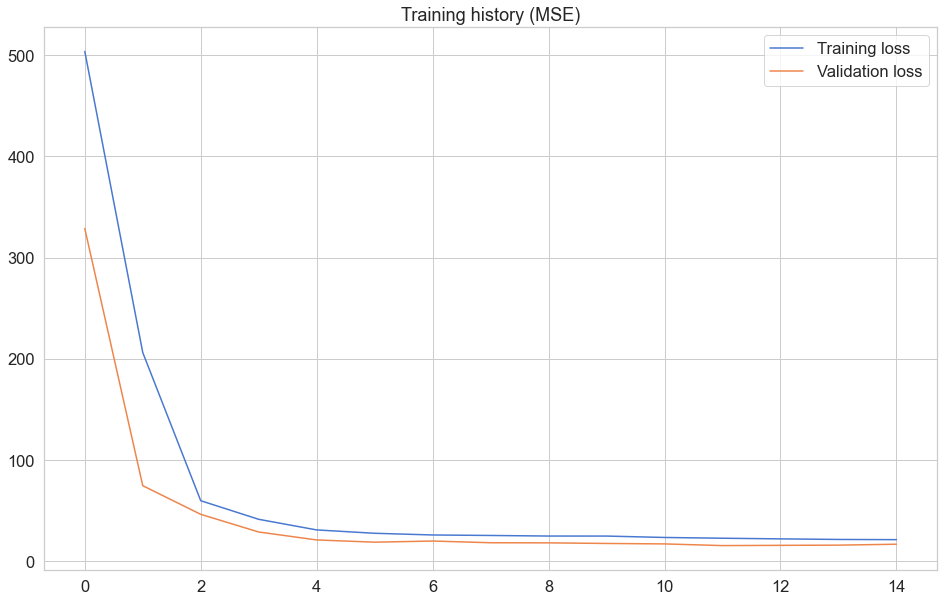

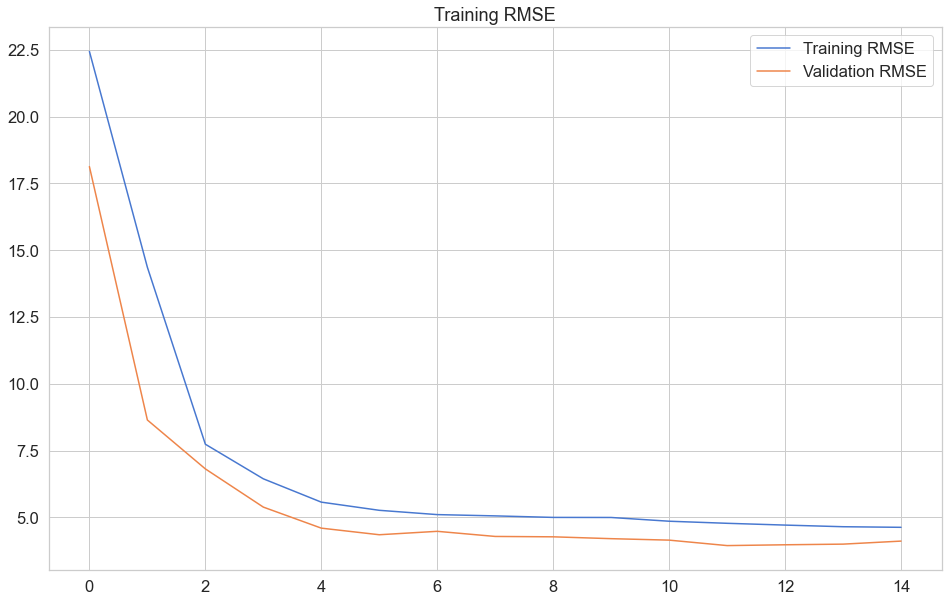

In [26]:
plot_history(history_1)

In [28]:
def plot_predictions(y_train, y_test, y_pred):
    plt.figure(figsize=(16,10))
    plt.plot(np.arange(0,len(y_train)), y_train, 'g', label = 'Training data')
    plt.plot(np.arange(len(y_train),len(y_train)+len(y_test)), y_test, marker = '.', label = 'True testing data')
    plt.plot(np.arange(len(y_train),len(y_train)+len(y_test)), y_pred, 'r', label = 'Predicted testing data')
    plt.legend()
    plt.title('Complete training+testing rundown')
    plt.show()
    
    plt.figure(figsize=(16,10))
    plt.plot(y_test, marker = '.', label = 'True testing data')
    plt.plot(y_pred, 'r', label = 'Predicted testing data')
    plt.legend()
    plt.title('Testing comparison')
    plt.show()

In [29]:
y_pred = model_1.predict(X_test)

In [30]:
y_pred[0]

array([28.912928], dtype=float32)

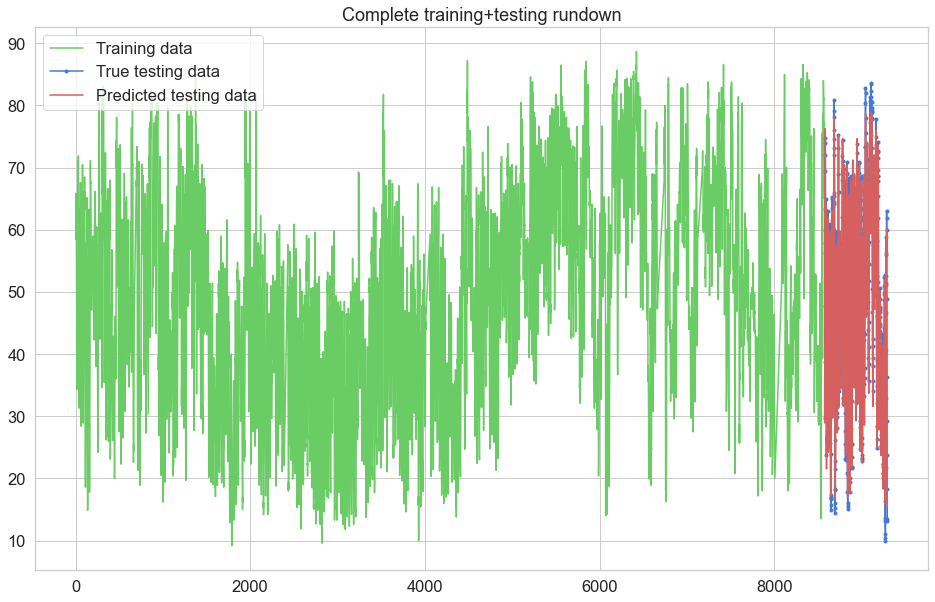

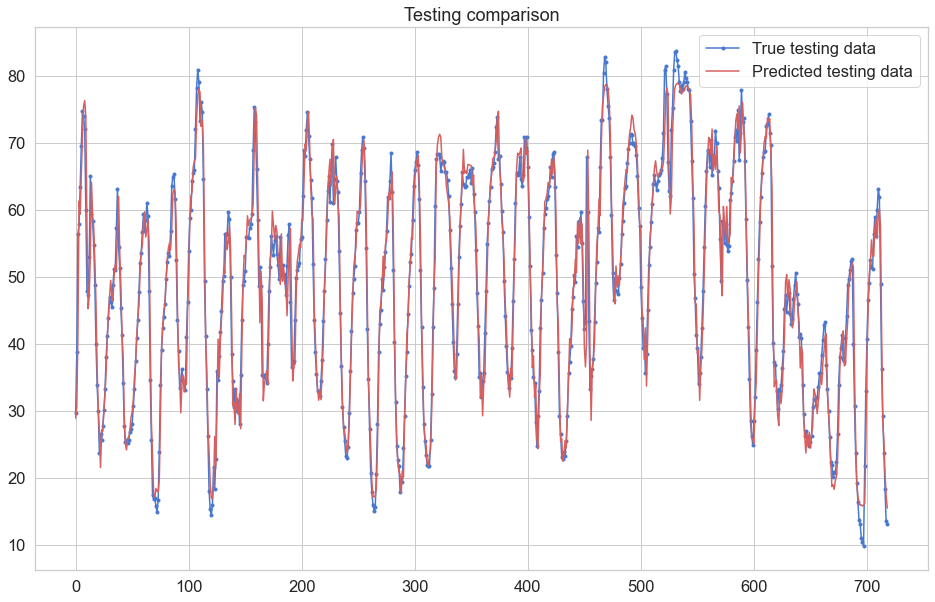

In [31]:
plot_predictions(y_train, y_test, y_pred)

# CONCLUSION

I succesfully trained a multivariate LSTM model on the previously edited data. The overall generalization of the model seems to be great. What I really appreciate is a successfull implementation of learning rate scheduling using a simple scheduler function, in the future I'd like to try out PolynomialDecay and other types of dynamic LR as well.